# Thesis
***

## Aspect BASED Sentiment Analysis
***
***

### Project Lifecycle 

* 1. Problem Statsement

* 2. Data Collection 

* 3. EDA

* 4. Machine Learning Approach

* 5. Result validation and Report

## Load Formatted Data

### Import library

In [4]:
import numpy as np
import pandas as pd
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt

import datapurifier as dp
from datapurifier import Mleda, Nlpeda, Nlpurifier, MlReport
from datapurifier import NLAutoPurifier

In [1]:
df = pd.read_csv('formatted_df.csv')

<IPython.core.display.Javascript object>

In [2]:
print(df.shape)

(49895, 5)


In [3]:
df.sample(2)

industry location_name  location_uid  \
13102  automotive-dealer    Sales - US       3603738   
14461  automotive-dealer    Sales - US       3603738   

                                                 comment  comment_num_words  
13102  The New Service has only (6) months coverage i...              124.0  
14461                          They guy was very helpful                5.0

# 4. Machine Learning Approach

Ref Paper: https://ieeexplore.ieee.org/document/9279217

* 4.1 Aspect Extraction  
* 4.2 Aspect Detection
* 4.3 Aspect's Sentiment detection

## 4.1 Extracting Aspects


* Hybrid combination of both frequency based approach (word level) and syntactic-relation based approach (sentence level) followed by semantic similarity based approach.

* Model should be able to Eliminate all the irrelevant aspects and should be able to extract all the semantically related aspects.



#### Illustration :
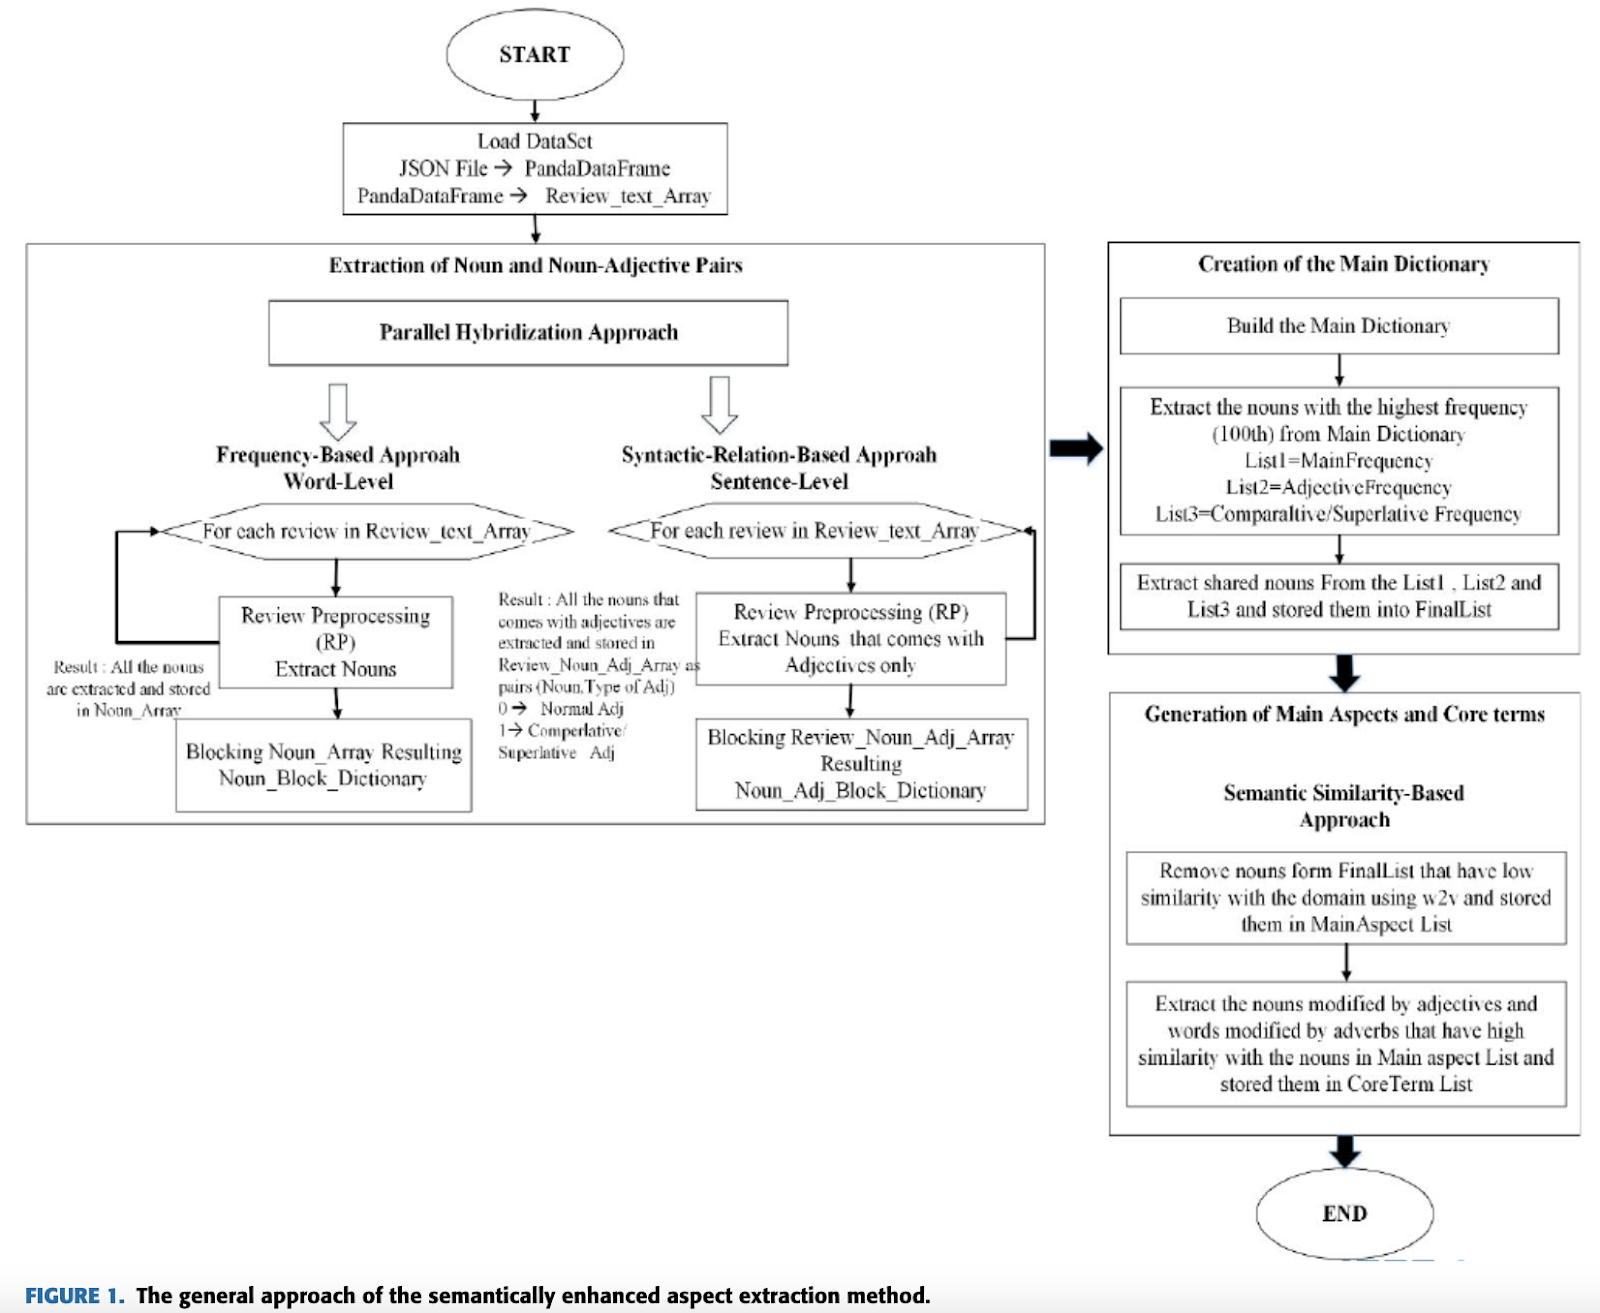

### Frequency Based Approach (word level)

Fixed list of aspects doesn't guarantee that it will be present in user generated reviews. Thus, aspects should be learnt continuously in such a way that they sufficiently represent user reviews. Therefore this FBA approach.
In the research, the words that represent aspects are mostly nouns, as result this phase mostly focuses on nouns and its occurrence extraction.

* Working -
    * Extract the nouns from the dataset
    * Calculate the occurrences
    * Stores the extracted nouns with their frequency in the blocks (i.e., clusters)
    * Blocking (hashing using dict) is done to reduce the search space and increase the search speed
    * Finally produces the Noun_Block_Dictionary

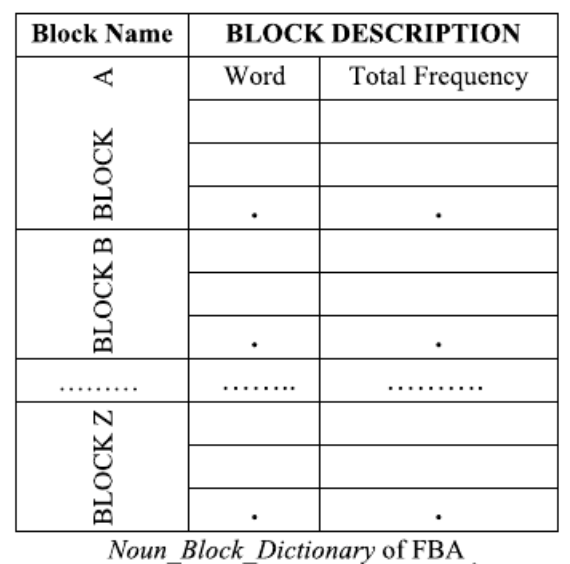

* Blocking - Reduce search space to accelerate the searching in large scale 
    * 27 blocks, named A to Z, numbered from 0 to 26.
    * Each block stores the nouns that begin with the same first letter.


In [5]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
import spacy
from tqdm import tqdm
from collections import Counter
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

def frequency_based(review_text_list):
    
    # Intitialise the Noun_Block_dictionary (27 block named A,B,C to Z)
    noun_block_dictionary = {}

    for char in range(65,91):
        noun_block_dictionary.setdefault(chr(char), {}) 

    
    for block_no in noun_block_dictionary:
        noun_block_dictionary[block_no]['WordList'] = []

        
    total_extracted_nouns = 0 # to present how many extracted word
    
    for review_text in tqdm(review_text_list):
        
        if len(review_text)<2:
            continue
        # print('review_text: ', review_text)
        word_tokenized = word_tokenize(review_text)
        
        # Clean text
        # ToDo:
        
        tagged_list = nltk.pos_tag(word_tokenized)
        words, tagger = zip(* tagged_list)
        
        for idx, word in enumerate(words):
            if tagger[idx].startswith('NN'):
                if len(word)>2:
                    
                    candidate_aspect = lemmatizer.lemmatize(word)
                    total_extracted_nouns += 1
                    
                    first_letter = candidate_aspect[0].upper() # Equivalant to block number ASCII(A) = 65
                    
                    if first_letter in noun_block_dictionary:
                        noun_block_dictionary[first_letter]['WordList'].append(candidate_aspect)

    for block_no in noun_block_dictionary:
        counter_dict = Counter(noun_block_dictionary[block_no]['WordList'])
        
        noun_block_dictionary[block_no]['Word'] = list(counter_dict.keys())
        noun_block_dictionary[block_no]['Frequency'] = list(counter_dict.values())    
        noun_block_dictionary[block_no]['WordFreqCounter'] = counter_dict
        assert len(noun_block_dictionary[block_no]['Frequency']) == len(noun_block_dictionary[block_no]['Word'])
         
     
    return noun_block_dictionary

* Using text hero as auto pipeline for data preprocessing 

Ref: https://texthero.org/

In [11]:
import texthero as hero

In [15]:
%%time

# Cleaning comment text
"""
# lowercase
# remove_digits
# remove_punctuation
# remove_diacritics
# remove_stopwords
# remove_whitespace
# Replace emoticon with words
"""

df['clean_comments'] = hero.clean(df['comment'])

Wall time: 1.81 s


In [26]:
print(f"Before: \n{df['comment'].iloc[0]}")
print('-'*100)
print(f"After: \n{df['clean_comments'].iloc[0]}")

Before: 
The representative that helped me was amazing. She was kind, professional and went over and beyond what I had expected!
----------------------------------------------------------------------------------------------------
After: 
representative helped amazing kind professional went beyond expected


In [27]:
%%time
# Get the aspects using noun freq based approach
noun_block_dictionary = frequency_based(df['clean_comments'].values)

100%|███████████████████████████████████████████████████████████████████████████| 49895/49895 [00:51<00:00, 961.08it/s]

Wall time: 51.9 s


###  Syntactic-Relation Based Approach (sentence level)

As mentioned in FBA, aspects are mostly nouns and nouns that come up with adjectives have more probability to be chosen as aspects. E.g.; “the company produces good movie” ; < movie, good > is the noun adjective pair and movie is the noun here.
Similar to FBA, It aims to extract noun-adjective pairs using grammar rules 

* Working -
    * Extract all the nouns in the dataset that comes with adjectives.
    * Calculate the frequencies of each noun based on adjectives’ degree. (i.e., positive, comparative/superlatives adjective). Calculate two specific frequencies only,  positive and comparative/superlatives adjectives.
    * Stores the extracted nouns with their adjective frequency in the blocks 
    * Finally produces the Noun_Adj_Block_Dictionary as output in the form of (<Block Number><Word> <freq Adjective><freq comparative/Superlative_Adjective>)

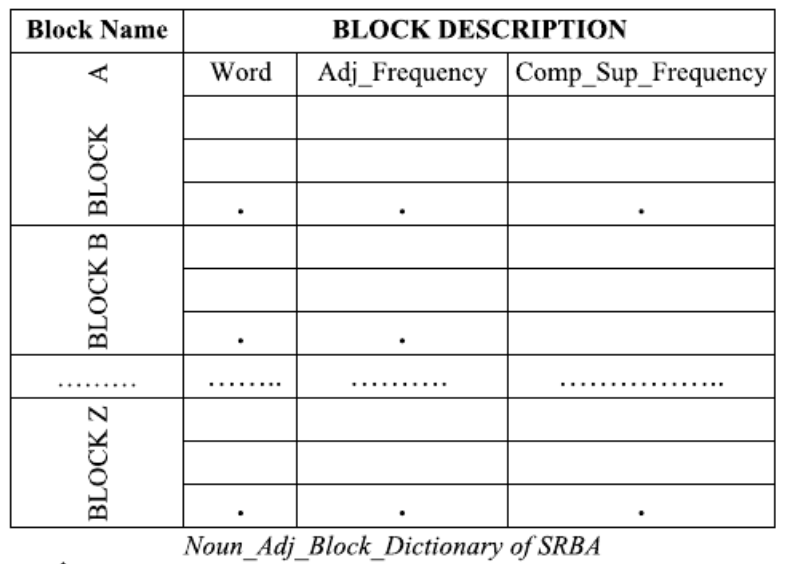

In [31]:
# Function to get the aspects using syntactic relation based approach
def syntantic_relation_based(review_text_array):
    
    noun_adj_block_dictionary = {}

    for char in range(65,91):
        noun_adj_block_dictionary.setdefault(chr(char), {}) 


    for block_no in noun_adj_block_dictionary:
        noun_adj_block_dictionary[block_no]['WordList'] = {}
    
    nlp = spacy.load('en_core_web_sm')
    
    total_extracted_nouns = 0 
    total_extracted_nouns2 = 0

    for review_text in tqdm(review_text_array):
        sentence_tokenized = sent_tokenize(review_text) # Split the sent into sentences

        for sentence in sentence_tokenized:
            # word_tokenized = word_tokenize(sentence)
            # sentence_pd_series = pd.Series(sentence)

            # Clean word tokenised list 
            # ToDo:
            # hero.remove_digits(sentence_pd_series)
            # hero.remove_digits(sentence_pd_series)
            # hero.remove_digits(sentence_pd_series)

            cleaned_sent = sentence
            if len(cleaned_sent)>1:

                doc = nlp(cleaned_sent)
                for chunk in doc.noun_chunks:
                    # print('chunk: ', chunk)

                    noun = ""
                    adj_flag = 0
                    for tok in chunk:
                        if tok.pos_ =='NOUN':
                            noun = tok.lemma_.lower()

                        if tok.pos_ =='ADJ':
                            adj_flag = 1


                    if len(noun)>2 and adj_flag:
                        # print(noun, adj_flag)
                        first_letter = noun[0].upper() # Equivalant to block number ASCII(A) = 65
                        if first_letter in noun_adj_block_dictionary:
                            noun_adj_block_dictionary[first_letter]['WordList'][noun] = noun_adj_block_dictionary[first_letter]['WordList'].get(noun, 0) + 1

    return noun_adj_block_dictionary

In [33]:
%%time
# Get the aspects using noun-adjective freq based approach
noun_adj_block_dictionary = syntantic_relation_based(df['comment'].values)

100%|███████████████████████████████████████████████████████████████████████████| 49895/49895 [05:27<00:00, 152.38it/s]

Wall time: 5min 27s


In [34]:
# Checking noun_adj_block_dictionary
for block_no in noun_adj_block_dictionary:
    counter_dict = Counter(noun_adj_block_dictionary[block_no]['WordList'])

    noun_adj_block_dictionary[block_no]['Word'] = list(noun_adj_block_dictionary[block_no]['WordList'].keys())
    noun_adj_block_dictionary[block_no]['Adj_Frequency'] = list(noun_adj_block_dictionary[block_no]['WordList'].values())  
    assert len(noun_adj_block_dictionary[block_no]['Adj_Frequency']) == len(noun_adj_block_dictionary[block_no]['Word'])


In [35]:
import pickle

# Save the dict - noun_block_dictionary
with open('noun_block_dictionary.pkl', 'wb') as f:
    pickle.dump(noun_block_dictionary, f)

# Save the dict - noun_adj_block_dictionary
with open('noun_adj_block_dictionary.pkl', 'wb') as f:
    pickle.dump(noun_adj_block_dictionary, f)
         


In [36]:
# Load the dict
with open('noun_block_dictionary.pkl', 'rb') as f:
    noun_block_dictionary = pickle.load(f)
    
with open('noun_adj_block_dictionary.pkl', 'rb') as f:
    noun_adj_block_dictionary = pickle.load(f)

### Creation of Main Dict

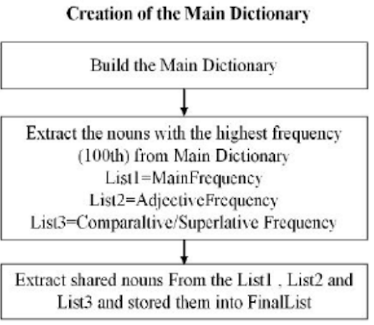

In [37]:
# Merge noun_block_dictionary and noun_adj_block_dictionary
def main_dict_building(noun_block_dictionary, noun_adj_block_dictionary):
    main_dict = {}

    for char in range(65,91):
        main_dict.setdefault(chr(char), {}) 


    for block_no in main_dict:
        main_dict[block_no]['Word'] = []
        main_dict[block_no]['Total_Freq'] = []
        main_dict[block_no]['Adj_Freq'] = []

    
    for block_no in noun_block_dictionary:
        
        main_dict[block_no]['Word'].extend(noun_block_dictionary[block_no]['Word'])
        main_dict[block_no]['Total_Freq'].extend(noun_block_dictionary[block_no]['Frequency'])
        main_dict[block_no]['Adj_Freq'].extend(len(noun_block_dictionary[block_no]['Frequency'])* [0])
        
        assert len(main_dict[block_no]['Word']) == len(main_dict[block_no]['Total_Freq'])
        assert len(main_dict[block_no]['Word']) == len(main_dict[block_no]['Adj_Freq'])
        

        for idx, word in enumerate(noun_adj_block_dictionary[block_no]['Word']):
            # check weather word is present in noun_block_dictionary[block_no]
            found_NABD = noun_block_dictionary[block_no]['WordFreqCounter'].get(word, 0)

            if found_NABD:
                word_index = noun_block_dictionary[block_no]['Word'].index(word)
                main_dict[block_no]['Adj_Freq'][word_index] = noun_adj_block_dictionary[block_no]['Adj_Frequency'][idx]
            else:
                
                main_dict[block_no]['Word'].append(word)
                main_dict[block_no]['Total_Freq'].append(0)
                main_dict[block_no]['Adj_Freq'].append(noun_adj_block_dictionary[block_no]['Adj_Frequency'][idx])
    
    for block_no in main_dict:
        assert len(main_dict[block_no]['Total_Freq']) == len(main_dict[block_no]['Word'])
        assert len(main_dict[block_no]['Adj_Freq']) == len(main_dict[block_no]['Word'])
        
    return main_dict


In [38]:
# Get the main dict
main_dict = main_dict_building(noun_block_dictionary, noun_adj_block_dictionary)

In [39]:
# Getting top 100 nouns and top 100 AdjMOD nouns 
top_k_freq = 100

main_word_list = []
main_word_noun_freq = []
main_word_adj_noun_freq = []

shared_words = set()

for block_no in tqdm(main_dict):
    main_word_list.extend(main_dict[block_no]['Word'])
    main_word_noun_freq.extend(main_dict[block_no]['Total_Freq'])
    main_word_adj_noun_freq.extend(main_dict[block_no]['Adj_Freq'])
    
    shared_words = shared_words.union(tuple(np.array(main_word_list)[np.argsort(main_word_noun_freq)[::-1][:top_k_freq]]))
    shared_words = shared_words.union(tuple(np.array(main_word_list)[np.argsort(main_word_adj_noun_freq)[::-1][:top_k_freq]]))
    

100%|█████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 225.88it/s]


In [40]:
def find_word_freq(word):
    
    return main_dict[word[0].upper()]['Total_Freq'][main_dict[word[0].upper()]['Word'].index(word)]

In [41]:
shared_words = list(shared_words)
shared_words_freq = [find_word_freq(word) for word in shared_words]

shared_words_freq_df = pd.DataFrame({"words": shared_words, 'freqency': shared_words_freq})

In [42]:
# display large dataframes in an html iframe
import IPython
def ldf_display(df, lines=500):
    txt = ("<iframe " +
           "srcdoc='" + df.head(lines).to_html() + "' " +
           "width=1000 height=500>" +
           "</iframe>")

    return IPython.display.HTML(txt)

In [55]:
print('All the aspect based on frequency: ')
shared_words_freq_df = shared_words_freq_df.sort_values(by = 'freqency', ascending=False)
ldf_display(shared_words_freq_df)

All the aspect based on frequency: 


#### Word cloud of frquency based aspects

Word cloud of frquency based aspects: 


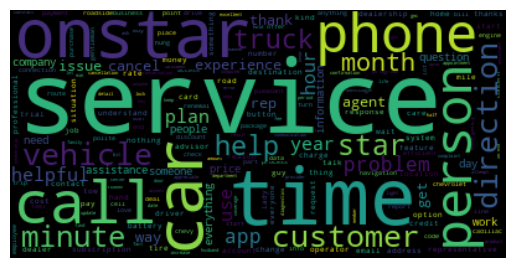

In [57]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Word cloud of frquency based aspects
print('Word cloud of frquency based aspects: ')
tuples = [tuple(x) for x in shared_words_freq_df.values]
wordcloud = WordCloud().generate_from_frequencies(dict(tuples))

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [50]:
# DYNAMIC Frequency aspects
freq_threshold = 30
ldf_display(shared_words_freq_df
         [shared_words_freq_df.iloc[np.argsort(shared_words_freq)[::-1]]['freqency']>freq_threshold])


In [54]:
# STATIC Frequency aspects
ldf_display(pd.DataFrame({"STATIC Frequency aspects": np.array(
    list(shared_words))[np.argsort(shared_words_freq)[::-1]][:100]}))

### Semantically Related Aspects

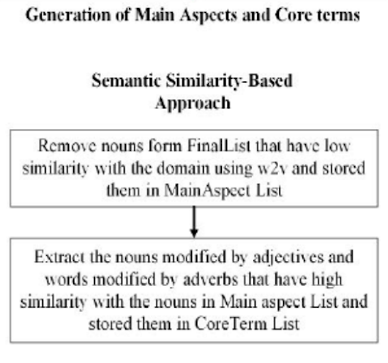

Note: Using BERT embeding instead of W2V embedding as it is giving better symantic relation

#### Domain specific categories

In [14]:
# Domain specific categories
aspect_label_terms = [
    'Sales',
     'Service',
     'Parts',
     'Leasing',
     'Finance',
     'Customer',
     'Competence',
     'Pricing',
     'Administration',
     'Speed',
     'Suggestion',
     'Appearance',
     'Cleanliness',
     'Test Drive',
     'Appointment',
     'Tactics',
     'Appearance',
     'Amenities',
     'Cleanliness',
     'Location',
     'Parking',
     'Experience',
     'Recommend'
]

print('Category selection using domain expertise: ')
pd.DataFrame({"Domain Aspects":aspect_label_terms})

Category selection using domain expertise: 


<IPython.core.display.Javascript object>

Domain Aspects
0            Sales
1          Service
2            Parts
3          Leasing
4          Finance
5         Customer
6       Competence
7          Pricing
8   Administration
9            Speed
10      Suggestion
11      Appearance
12     Cleanliness
13      Test Drive
14     Appointment
15         Tactics
16      Appearance
17       Amenities
18     Cleanliness
19        Location
20         Parking
21      Experience
22       Recommend

In [16]:
aspect_label_terms

['Sales',
 'Service',
 'Parts',
 'Leasing',
 'Finance',
 'Customer',
 'Competence',
 'Pricing',
 'Administration',
 'Speed',
 'Suggestion',
 'Appearance',
 'Cleanliness',
 'Test Drive',
 'Appointment',
 'Tactics',
 'Appearance',
 'Amenities',
 'Cleanliness',
 'Location',
 'Parking',
 'Experience',
 'Recommend']

In [117]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Transformer model
sent_model = SentenceTransformer('all-MiniLM-L6-v2')

def BERT_EMBEDING(data):
    
    vector_of_terms = []
    
    for word in data:
        vector_of_terms.append(sent_model.encode(word))
    
    return vector_of_terms, list(data)

In [118]:
candidate_aspects = np.array(shared_words) 
bert_output = BERT_EMBEDING(candidate_aspects)

aspect_label_terms = list(pd.Series(aspect_label_terms).apply(lambda x: x.lower()))

aspect_label_terms_vectors = []
aspect_label_vocab_terms = []
for aspect in aspect_label_terms:
    aspect_label_terms_vectors.append(sent_model.encode(aspect))
    aspect_label_vocab_terms.append(aspect)
    

In [119]:
aspect_core_terms = defaultdict(list)
aspect_core_terms_list = defaultdict(list)

THRES = 0.5
for idx, word_vector in enumerate(bert_output[0]):
    sim_output = cosine_similarity([word_vector], aspect_label_terms_vectors)
    
    max_sim_idx = np.argmax(sim_output)
    
    if sim_output[0][max_sim_idx]> THRES:
        aspect_core_terms[aspect_label_terms[max_sim_idx]].append((bert_output[1][idx], np.round(sim_output[0][max_sim_idx], 2)))
        aspect_core_terms_list[aspect_label_terms[max_sim_idx]].append(bert_output[1][idx])
        
        

In [128]:
word_adj_freq = []
word_adj_list = []
word_freq_greater_than_30 = set()

for block_no in tqdm(noun_adj_block_dictionary):
    word_adj_list.extend(noun_adj_block_dictionary[block_no]['Word'])
    word_adj_freq.extend(noun_adj_block_dictionary[block_no]['Adj_Frequency'])

    word_freq_greater_than_30 = word_freq_greater_than_30.union(tuple(np.array(word_adj_list)[np.array(word_adj_freq)>30]))
    

100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 2597.71it/s]


In [130]:
THRES = 0.5

bert_output_low_freq = BERT_EMBEDING(list(word_freq_greater_than_30))

for idx, word_vector in enumerate(bert_output_low_freq[0]):
    sim_output = cosine_similarity([word_vector], aspect_label_terms_vectors)
    
    max_sim_idx = np.argmax(sim_output)
    
    if sim_output[0][max_sim_idx]> THRES:
        aspect_core_terms[aspect_label_terms[max_sim_idx]].append((bert_output_low_freq[1][idx], np.round(sim_output[0][max_sim_idx], 2)))
        if bert_output_low_freq[1][idx] not in aspect_core_terms_list[aspect_label_terms[max_sim_idx]]:
            aspect_core_terms_list[aspect_label_terms[max_sim_idx]].append(bert_output_low_freq[1][idx])
            aspect_core_terms[aspect_label_terms[max_sim_idx]].append(bert_output_low_freq[1][idx])
        

In [132]:
# All the aspects and aspects seed term
print('List of the aspects and aspects seed term: ')
ldf_display(pd.DataFrame({
    "aspects": list(aspect_core_terms_list.keys()),
    "aspect terms": list(aspect_core_terms_list.values())
}))

List of the aspects and aspects seed term: 


In [133]:
# Chossing only subset of aspect for experiment 

final_aspects_list = {
    'FINANCE': aspect_core_terms_list['finance'],
    'ADMINISTRATION': aspect_core_terms_list['administration'],
    'COMPETENCE': aspect_core_terms_list['competence'],
    'SALES': aspect_core_terms_list['sales'],
    'PRICING': aspect_core_terms_list['pricing'],
    'SERVICE': aspect_core_terms_list['service'],
    'CUSTOMER': aspect_core_terms_list['customer'],
    'EXPERIENCE': aspect_core_terms_list['experience'],
}

print('Final Aspect terms and aspect seed words: ')
ldf_display(pd.DataFrame({
    "aspects": list(final_aspects_list.keys()),
    "aspect terms": list(final_aspects_list.values())
}))

Final Aspect terms and aspect seed words: 


In [134]:
# Save the Final dict of aspects
with open("final_aspects_list.pkl", "wb") as tf:
    pickle.dump(final_aspects_list,tf)

In [6]:
# Load the Final dict of aspects
with open("final_aspects_list.pkl", "rb") as tf:
    final_aspects_list = pickle.load(tf)

<IPython.core.display.Javascript object>

In [19]:
# display large dataframes in an html iframe
import IPython
def ldf_display(df, lines=500):
    txt = ("<iframe " +
           "srcdoc='" + df.head(lines).to_html() + "' " +
           "width=1000 height=500>" +
           "</iframe>")

    return IPython.display.HTML(txt)

ldf_display(pd.DataFrame({
    "aspects": list(final_aspects_list.keys()),
    "aspect terms": list(final_aspects_list.values())
}))

<IPython.core.display.Javascript object>

C:\Users\Adi\AppData\Roaming\Python\Python37\site-packages\IPython\core\display.py:724: UserWarning:

Consider using IPython.display.IFrame instead



## Cluster visualisation of Final aspects

In [7]:
# Get all the aspect's seed words
all_aspects = []
for aspects in final_aspects_list.values():
    all_aspects.extend(aspects)
    
reverese_aspect_dict = {}
for key, aspect_term_list in list(final_aspects_list.items()):
    for aspect_term in aspect_term_list:
        reverese_aspect_dict[f"{aspect_term}"]=key
        

In [8]:
aspect_df = pd.DataFrame({
    'aspect_term': list(reverese_aspect_dict.keys()),
    "aspect": list(reverese_aspect_dict.values())})

<IPython.core.display.Javascript object>

In [9]:
aspect_df

aspect_term          aspect
0            money         FINANCE
1           credit         FINANCE
2            asset         FINANCE
3           income         FINANCE
4          billing         FINANCE
5             bank         FINANCE
6          advisor  ADMINISTRATION
7   representative  ADMINISTRATION
8        authority  ADMINISTRATION
9          adviser  ADMINISTRATION
10      department  ADMINISTRATION
11           staff  ADMINISTRATION
12       assistant  ADMINISTRATION
13  administration  ADMINISTRATION
14          agency  ADMINISTRATION
15           agent  ADMINISTRATION
16       knowledge      COMPETENCE
17      capability      COMPETENCE
18      confidence      COMPETENCE
19           skill      COMPETENCE
20           buyer           SALES
21     advertising           SALES
22      dealership           SALES
23        business           SALES
24          dealer           SALES
25       promotion           SALES
26             fee         PRICING
27          afford         PRICING
28          dollar         PRICING
29        purchase         PRICING
30            rate         PRICING
31            deal         PRICING
32             buy         PRICING
33           price         PRICING
34            cost         PRICING
35         expense         PRICING
36         payment         PRICING
37          charge         PRICING
38        discount         PRICING
39          budget         PRICING
40          amount         PRICING
41          buying         PRICING
42          system         SERVICE
43        provider         SERVICE
44             job         SERVICE
45         service         SERVICE
46         aervice         SERVICE
47      assistance         SERVICE
48          person        CUSTOMER
49         company        CUSTOMER
50         product        CUSTOMER
51        customer        CUSTOMER
52        employee        CUSTOMER
53         someone        CUSTOMER
54      experience      EXPERIENCE

In [10]:
from sentence_transformers import SentenceTransformer, util

# Get the embeddings of all the seed words
model = SentenceTransformer('all-MiniLM-L6-v2')

aspects_embeddings = model.encode(all_aspects, convert_to_tensor=False)

In [11]:
from umap import UMAP
import plotly.express as px

# UMAP projection visualisation
umap_2d = UMAP(n_components=2, init='random', random_state=0)
proj_2d = umap_2d.fit_transform(aspects_embeddings)

aspect_df['comp_1'] = proj_2d[:,0]
aspect_df['comp_2'] = proj_2d[:,1]

#### Cluster plot

In [12]:
# Plot 
print('Aspects clusters: ')
fig_2d = px.scatter(
    aspect_df, x='comp_1', y='comp_2',color = 'aspect')
fig_2d.show()

Aspects clusters: 


In [152]:
# Save the embedding csv for report
aspect_df.to_csv('apects.csv', index=False)

In [157]:
aspect_df.head(2)

aspect_term   aspect    comp_1    comp_2
0       money  FINANCE  3.407362  4.557433
1      credit  FINANCE  4.345041  3.641393

End